In [3]:
%load_ext autoreload
%autoreload 2
    
from d3pm_sc.ct_sched_cond import ScheduleCondition
from d3pm_sc.masking_diffusion import MaskingDiffusion
from d3pm_sc.d3pm_classic import D3PMClassic
from d3pm_sc.unet import UNet, SimpleUNet
from d3pm_sc.dit import DiT_Llama
from d3pm_sc import utils
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger


import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10
from torchvision.utils import make_grid
from tqdm import tqdm

from matplotlib import pyplot as plt

In [4]:
N = 4  # number of classes for discretized state per pixel
n_channel = 1
gamma = 0
hybrid_loss_coeff=0.01
logistic_pars = True
fix_x_t_bias = True

s_dim = 4
conditional = True
forward_kwargs = {"type":"uniform",
                  "normalized": False,
                  "bandwidth":1 / 2}

batch_size = 16
n_epoch = 14

nn_params = {"n_channel": n_channel, 
             "N": N,
             "n_T": 500,
             "schedule_conditioning": True,
             "s_dim":4,
            }
x0_model_class = SimpleUNet

# x0_model_class = DiT_Llama
# nn_params['dim'] = 1024

##### Pick model
# Schedule conditioning
model = ScheduleCondition(x0_model_class, nn_params, num_classes=N, hybrid_loss_coeff=hybrid_loss_coeff, gamma=gamma,
                          forward_kwargs=forward_kwargs, logistic_pars=logistic_pars, fix_x_t_bias=fix_x_t_bias)

# # Masking
# nn_params["N"] += 1
# nn_params["schedule_conditioning"] = False
# model = MaskingDiffusion(x0_model_class, nn_params, num_classes=N, hybrid_loss_coeff=0.01).cuda()


##### Load data
dataset = MNIST(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
)
def collate_fn(batch):
    x, cond = zip(*batch)
    x = torch.stack(x)
    cond = torch.tensor(cond)
    cond = (cond * conditional)
    x = (x * (N - 1)).round().long().clamp(0, N - 1)
    return x, cond
train_size = int(len(dataset) * 0.9)
dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=16, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, collate_fn=collate_fn)


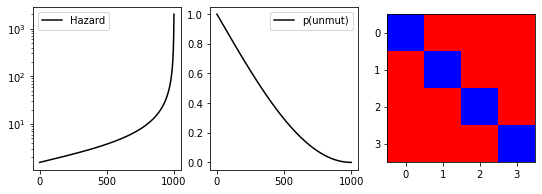

In [5]:
steps = torch.arange(1000 + 1, dtype=torch.float64) / 1000

fig, ax = plt.subplots(1, 3, figsize=[9, 3])
ax[0].semilogy(model.beta(steps), label="Hazard", color='black')
ax[0].legend()

alpha_bar = torch.exp(model.log_alpha(steps))
ax[1].plot(alpha_bar, label="p(unmut)", color='black')
ax[1].legend()

L = utils.get_inf_gens(forward_kwargs, N)
ax[2].imshow(L, vmin=-0.1, vmax=0.1, cmap='bwr')

In [6]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger(project="debugging")
lightning_model = model

trainer = Trainer(max_epochs=n_epoch, accelerator='auto', devices='auto', logger=wandb_logger)
trainer.fit(lightning_model, dataloader, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Currently logged in as: alanamin. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
/home/alan_a/.local/lib/python3.10/site-packages/pytorch_lightning/core/optimizer.py:377: Found unsupported keys in the optimizer configuration: {'gradient_clip_algorithm', 'gradient_clip_val'}

  | Name     | Type       | Params | Mode 
------------------------------------------------
0 | x0_model | SimpleUNet | 1.9 M  | train
------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.662     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                         | 0…

AssertionError: 

In [ ]:
wandb.finish()

In [9]:
evals, evecs = torch.linalg.eig(model.K.T)

In [15]:
torch.argmax(torch.real(evals * evals.conj()))

tensor(1)

In [12]:
torch.norm(evals)

tensor(1.1547)

In [10]:
evals[torch.argmax(torch.norm(evals))]

tensor(-0.3333+0.j)

In [7]:
model.get_stationary()

AssertionError: 